In [5]:
# 自定义数据集
# 1.构造torch自定义dataset
# 2.数据增强
# 3.dataloader加载
# 4.测试一组数据

In [6]:
import torch
import matplotlib.pyplot as plt
import glob
import numpy as np

In [7]:
# 自定义构造dataset
from torch.utils.data import Dataset,DataLoader

In [8]:
class SegmentDataset(Dataset):
    def __init__(self, where = 'train'):
        # 获取npy文件
        # 图片列表
        self.img_list = glob.glob('processed/{}/*/img_*'.format(where))


    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        # 获取具体某一个数据
        img_file = self.img_list[idx]
        # 获取标注文件名
        mask_file = img_file.replace('img','label')

        # 加载
        img = np.load(img_file)
        mask = np.load(mask_file)

        # 扩张维度变为张量
        return np.expand_dims(img,0),np.expand_dims(mask,0)

In [11]:
# 加载训练集所有图片
dataset = SegmentDataset('train')
len(dataset)

1932

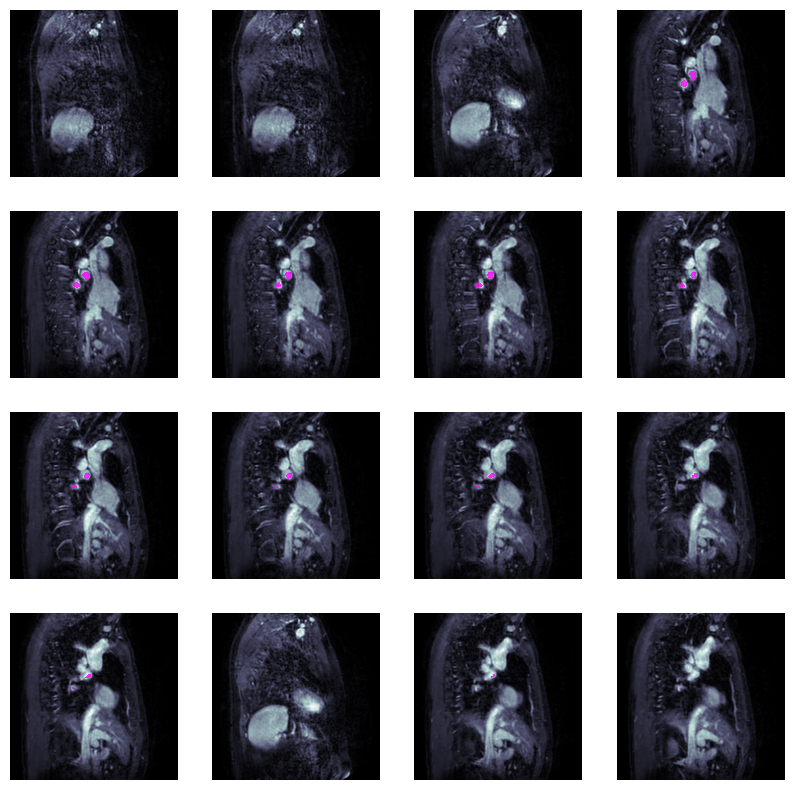

In [12]:
# 随机显示图片
fig = plt.figure(figsize=(10,10))
for i in range(16):  # 显示16张图片
    plt.subplot(4,4,i+1)
    # 获取图片
    img,mask = dataset[i]
    # 将mask和图片绘制在一起
    img_display = np.rot90(img[0])
    mask_display = np.rot90(mask[0])

    # 将mask_display像素值为0的区域遮挡起来
    mask = np.ma.masked_where(mask_display == 0, mask_display)
    plt.imshow(img_display, cmap='bone')
    plt.imshow(mask, alpha=0.8, cmap='spring')

    plt.axis('off')

plt.show()

In [13]:
# 做数据增强
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [14]:
class SegmentDataset(Dataset):
    def __init__(self, where = 'train',seq = None):  # 根据需要是否做数据增强（seq）
        # 获取npy文件
        # 图片列表
        self.img_list = glob.glob('processed/{}/*/img_*'.format(where))
        # 数据增强的处理
        self.seq =seq

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        # 获取具体某一个数据
        img_file = self.img_list[idx]
        # 获取标注文件名
        mask_file = img_file.replace('img','label')

        # 加载
        img = np.load(img_file)
        mask = np.load(mask_file)


        # 数据增强
        if self.seq:
            segmap = SegmentationMapsOnImage(mask,mask.shape)
            img,mask = self.seq(image = img,segmentation_maps = segmap)
            # 获取数组内容
            mask = mask.get_arr()
        # 扩张维度变为张量
        return np.expand_dims(img,0),np.expand_dims(mask,0)

In [15]:
# 数据增强的处理流程
seq = iaa.Sequential([
    iaa.Affine(
        scale=(0.8,1.2),  # 缩放
        rotate=(-45,45),   #旋转

    ),
    iaa.ElasticTransformation()  # 弹性形变
])

In [16]:
dataset = SegmentDataset('train',seq)

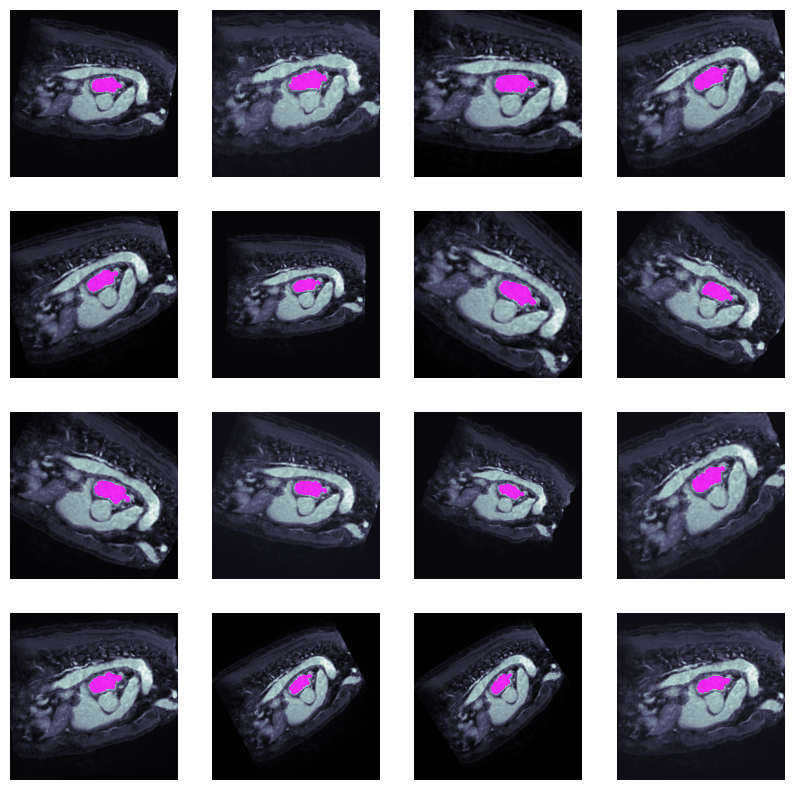

In [18]:
# 对同一数据增强，查看效果
fig = plt.figure(figsize=(10,10))
for i in range(16):  # 显示16张图片
    plt.subplot(4,4,i+1)
    # 获取图片
    img,mask = dataset[100]  # 固定住，只获取第100个数据
    # 将mask和图片绘制在一起
    img_display = img[0]
    mask_display = mask[0]

    # 将mask_display像素值为0的区域遮挡起来
    mask = np.ma.masked_where(mask_display == 0, mask_display)
    plt.imshow(img_display, cmap='bone')
    plt.imshow(mask, alpha=0.8, cmap='spring')

    plt.axis('off')

plt.show()

In [20]:
# Dataloader加载数据
batch_size = 16
num_workers = 0

train_dataset = SegmentDataset('train',seq)
test_dataset = SegmentDataset('test',None)

# dataloader
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,num_workers=num_workers,shuffle=False)


len(train_loader)  #1932/16

(121, 22)

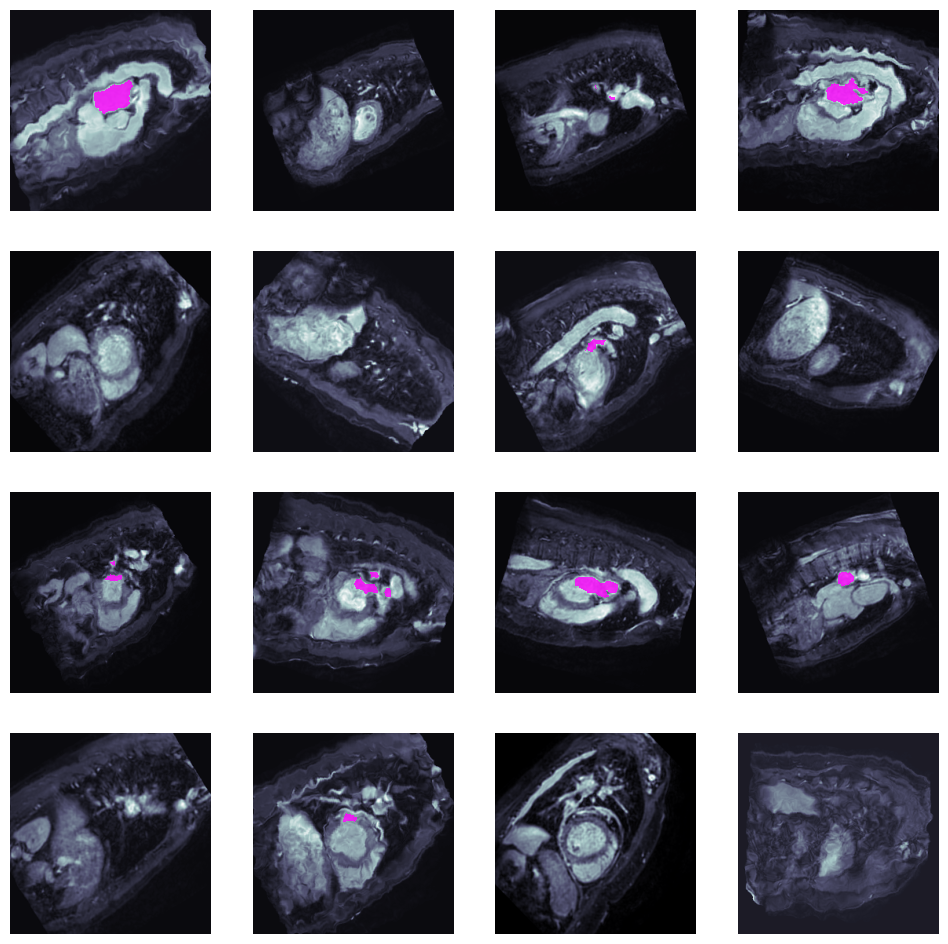

In [22]:
# 使用loader加载图片
for x in train_loader:
    fig = plt.figure(figsize=(12,12))
    for i in range(16):
        plt.subplot(4,4,i+1)

        img,mask = x[0][i][0],x[1][i][0]  # 获取图片及标注
        # 将mask_display像素值为0的区域遮挡起来
        mask = np.ma.masked_where(mask == 0, mask)
        plt.imshow(img, cmap='bone')
        plt.imshow(mask, alpha=0.8, cmap='spring')
        plt.axis('off')

    plt.show()
    break

